In this document, we explore the usage of ODE solver in Python and we attempt to model several physical process in CH160. Notice that the method described below are not specific to the Python language - any ODE solver should be able to reproduce similar results.

**Problem 1 - Cold-head stage heating**

Consider the heating process of CH160's copper stage. Ignore the temperature distribution of the copper and we have:

$$mc_p \frac{dT}{dt} = \dot Q$$

where m is the mass of the copper stage (=6.78kg), cp is the specific heat of copper, and $\dot Q$ is the input heat. Notice the heat capacity of copper depends on its temperature. 

The following function calculates copper's heat capacity based on [NIST's formula for OFHC](https://trc.nist.gov/cryogenics/materials/OFHC%20Copper/OFHC_Copper_rev1.htm).

Text(0, 0.5, 'Copper heat capacity (J/k-kg)')

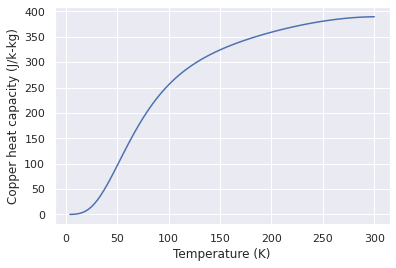

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

def copper_specheat(t):
  """ Return the specific heat of copper (J/K-kg) """
  from numpy import log10
  a = -1.91844
  b = -0.15973
  c = 8.61013
  d = -18.996
  e = 21.9661
  f = -12.7328
  g = 3.54322
  h = -0.3797
  logy = a + b*log10(t) + c*(log10(t))**2 + d*(log10(t))**3 +\
  e*(log10(t))**4 + f*(log10(t))**5 + g*(log10(t))**6 + h*(log10(t))**7
  return 10**logy

t = np.linspace(4,300,100)
plt.plot(t, copper_specheat(t))
plt.xlabel("Temperature (K)")
plt.ylabel("Copper heat capacity (J/k-kg)")

Now assume the heat load $\dot Q$ is constant and rearrange the equation :

$$ \frac{dT}{dt} = \frac{\dot Q}{m c_P(T)}$$

which is a typical first-order ODE (non-linear).

To solve the equation using the initial value problem solver ```solve_ivp()``` from scipy, we need to give a function that calculates the right-hand side of the equation. In this case, the right-hand side is:
$\frac{\dot Q}{m c_P(T)}$. We encapsulate this in ``` derv(t, T)``` and pass it to ```solve_ivp()```

Text(0, 0.5, 'Temperature (K)')

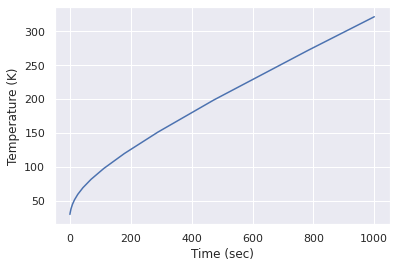

In [3]:
def derv(t, T): 
  """ Calculate the derivative of T against t. """
  m = 6.78  # mass of the copper stage
  Q = 600   # heat load 
  return Q / ( m * copper_specheat(T) )

from scipy.integrate import solve_ivp

T_sol = solve_ivp(fun = derv,t_span =  [0,1000,100], y0 = [30], rtol = 1.e-5)
plt.plot(T_sol.t, T_sol.y[0])
plt.xlabel("Time (sec)")
plt.ylabel("Temperature (K)")

The result shows the copper stage will warm up from 30K to 300K in about 15 mins, which is close to our observation in experiments.


**Problem 2 - Maximum pressure in the cyliner**
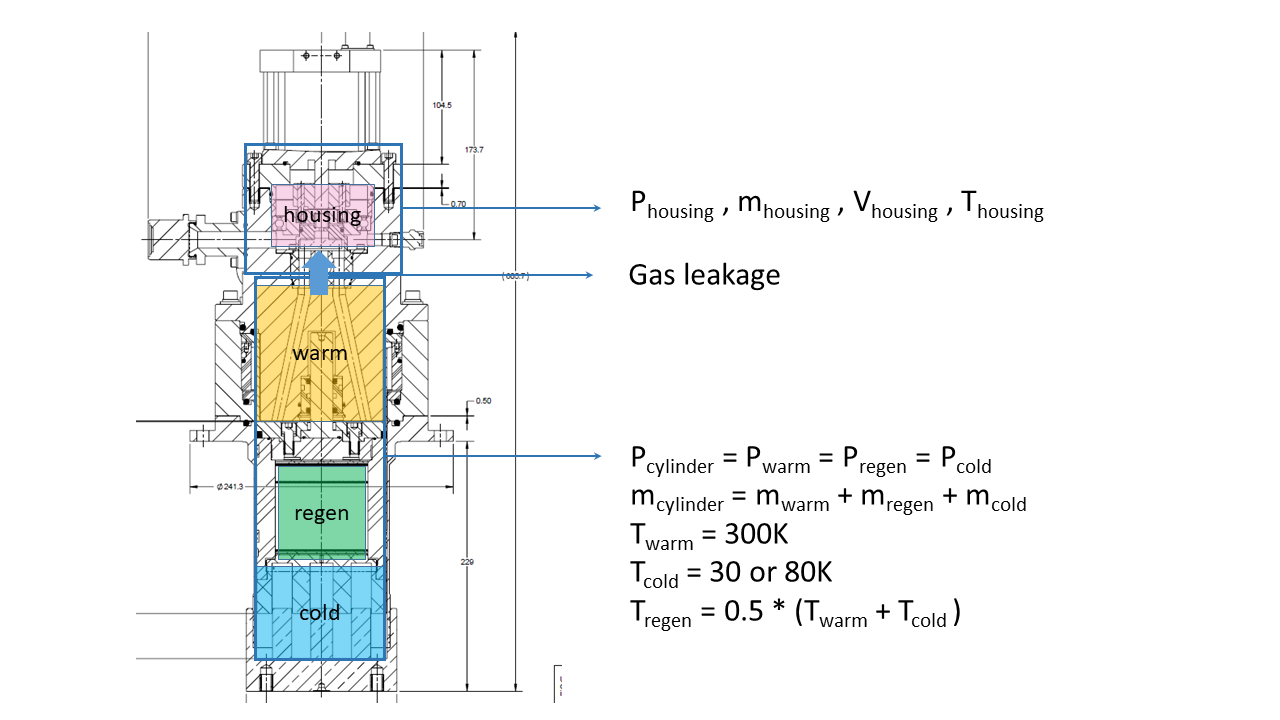

As the second example, we attempt to analyze the maximum possible pressure when the cold-head is disconnected from the compressor while cold. Assume the cold end temperature is 30K, and a 600W active heat is applied to the cold-head (which is the worst case and unlikely to happen in reality).

The problem is, when the valve disk is at a position where the cylinder space is isolated (not connected to the housing), the pressure will build up in the cylinder, and we want to know that maximum pressure in order to do proper strength design. The only leakage path is through the valve into the housing. And that leakage rate was measured by Stephen D. and Qian B. in an experiment using the flow meter.

Text(0, 0.5, 'Leak rate (g/sec)')

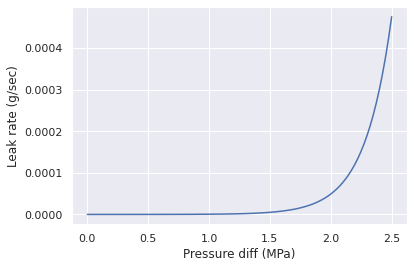

In [9]:
def leakage(ph, pl):
  """Gas leakage rate equation based on experiment; equation made by Stephen D."""
  return 4.9743e-6 * np.exp(4.5424 * (ph - pl)) * 0.001 * 1.1179


ph = np.linspace(0.5,3.0,100)
pl = 0.5
plt.plot(ph-pl, leakage(ph,pl))
plt.xlabel("Pressure diff (MPa)")
plt.ylabel("Leak rate (g/sec)")

The goal is to solve the pressure in the cylinder and in the housing. For both the cylinder and the housing, the only mass flow is the leakage through the valve disk. Therefore:

$$ \frac{dm_{c}}{dt}=-leakage(P_c, P_h)$$
$$ \frac{dm_{h}}{dt}=leakage(P_c, P_h)$$

Where $m_c$ stands for the helium mass in the cylinder, and $m_h$ stands for the helium mass in the housing. Notice the minus sign on the first equation, because the cylinder is losing helium gas.

To solve the equations, we also need to know the pressure in the cylinder and the housing. For this, we use the ideal gas equation:

$$ PV = mRT $$

Where R is helium's gas constant = 2076.9 (J/kg-K).
Also, we need to know the temperature of each part of the cold-head. 

- For the housing, we assume the temperature is 300K.
- For the cylinder, we need to solve the thermal conduction equation together with the the equations above.
Therefore, we need to solve the following 3 equations together:

$$ \frac{dm_{c}}{dt}=-leakage(P_c (m_c, T_c), P_h(m_h, T_h))$$
$$ \frac{dm_{h}}{dt}=leakage(P_c (m_c, T_c), P_h(m_h, T_h))$$
$$ \frac{dT_c}{dt} = \frac{\dot Q}{m c_P(T_c)}$$

(Check: 3 equations, 3 unknowns $m_c$, $m_h$ and $T_c$)

To begin the calculation, we first initialize some variables:

In [ ]:
# Mass of copper stage (kg)
copper_mass = 6.78
heat_load = 600

# Cold end volume (m^3)
# Regenerator void volume (m^3)
# Warm end volume; below valve disk, including the gas paths (m^3)
# Housing volume; measured by Hank (m^3)
cold_V = 0.00045216
rege_V = 0.00025622
warm_V = 9.129e-5
hous_V = 0.00043325

# Initial helium mass in the cylinder and the housing (kg)
m_cylinder = 0.00846468
m_housing = 0.7 * hous_V * 10**6  / 2077.1 / 300

Then we establish the right hand side of our equations. Notice now ```y``` is a tuple of 3 values, and ```derv(t,y)``` now returns a tuple of 3 values, which are the derivatives of $m_c$, $m_h$ and $T_c$.

In the calculation, we take into account the temperature distribution of the cylinder by dividing it into 3 parts:

- The copper stage
- The regenerator 
- The warm part

Since the pressure in those 3 parts are all the same, we have:

$$ m_c = \frac{P_c V_{warm}}{RT_{warm}} + 
\frac{P_c V_{rege}}{RT_{rege}} +
\frac{P_c V_{cold}}{RT_{cold}}$$ 

$$ P_c = m_c / ( \frac{V_{warm}}{RT_{warm}} + 
\frac{V_{rege}}{RT_{rege}} +
\frac{V_{cold}}{RT_{cold}}) $$

Use the equation above to calculate pressure in the cylinder when we know the helium mass from the previous time step.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


Text(0, 0.5, 'Pressure (MPa)')

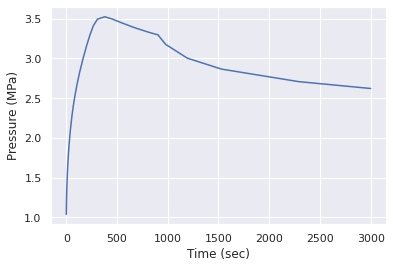

In [10]:

def derv(t, y):
  # y[0] - cold_T
  # y[1] - m_housing
  # y[2] - m_cylinder
  dydt = [0,0,0]
  
  # No heating > 300K
  dydt[0] = heat_load / ( copper_mass * copper_specheat(y[0]) ) if y[0] < 300 else 0.0

  RT1 = warm_V / (2077.1 * 300)
  RT2 = cold_V / (2077.1 * y[0])
  RT3 = rege_V / (2077.1 * (300 + y[0]) * 0.5)
  RT4 = hous_V / (2077.1 * 300)
  P_housing = (y[1] / RT4 / 10**6)
  P_cylinder = y[2] / (RT1 + RT2 + RT3) / 10**6

  dydt[1] = 0.0 if P_housing > 1.93 else leakage(P_cylinder, P_housing)
  dydt[2] = -leakage(P_cylinder, 1.93) if P_housing > 1.93 else -leakage(P_cylinder, P_housing)

  return dydt

sol = solve_ivp(fun = derv,t_span =  [0,3000,100], y0 = [30, m_housing, m_cylinder ], rtol = 1.e-8)

RT1 = warm_V / (2077.1 * 300)
RT2 = cold_V / (2077.1 * sol.y[0])
RT3 = rege_V / (2077.1 * (300 + sol.y[0]) * 0.5)
RT4 = hous_V / (2077.1 * 300)
p_cylinder = sol.y[2] / (RT1 + RT2 + RT3) / 10**6
p_housing = sol.y[1] / RT4 / 10**6
plt.plot(sol.t, p_cylinder)

plt.xlabel("Time (sec)")
plt.ylabel("Pressure (MPa)")


We pass the ```derv(t, y)``` function to ```solve_ivp``` and obtain the results.

The maximum pressure is around 3.5MPa.